In [1]:
import loader 
import tensorflow as tf

In [2]:
config = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03_testexport/args_load.json"
model_weights = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03_testexport/weights.best.hdf5"

In [3]:
model,dataset,tf_data = loader.get_model_and_dataset( config, model_weights, training=False, overwrite={"batch_size":512} )

Model options: 
{'activation': 'elu',
 'batch_size': 512,
 'coord_dim': 3,
 'coord_dim_sa': 15,
 'data_definition_path': '/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03_testexport/tf_data.py',
 'data_path': {'ele_match': '/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/dataset/electrons/recordio_allinfo_v11/training/calo_matched/*.proto',
               'gamma_match': '/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/dataset/gammas/recordio_allinfo_v11/training/calo_matched/*.proto'},
 'dropout': 0.1,
 'features_dict': {'cl_features': ['en_cluster',
                                   'et_cluster',
                                   'cluster_eta',
                                   'cluster_phi',
                                   'cluster_ieta',
                                   'cluster_iphi',
                                   'cluster_iz',
                                   'cluster_deta',
                           

In [4]:
seed_et_lim = [2,30]
seed_eta_lim = [0.8, 1.4]

In [5]:
Tin_etaphis = []
Tout_etaphis = []
Tin_m_etaphis = []
Tout_m_etaphis = []

Fin_etaphis = []
Fout_etaphis = []
Fin_m_etaphis = []
Fout_m_etaphis = []

In [6]:
for X,y,w in dataset.take(2000):
    print('.', end="")
    y_out = model(X, training=False)
    cl_X_initial, wind_X_norm , cl_hits, is_seed,n_cl = X
    
    dense_clclass = y_out["cl_class"]
    mask_cls = y_out["mask_cls"]
    
    pred_prob = tf.nn.sigmoid(dense_clclass) * mask_cls[:,:,tf.newaxis]
    y_pred = tf.cast(pred_prob >= 0.5, tf.float32)
    
    
    y_clclass, y_windclass, cl_X, wind_X, y_metadata, cl_labels = y
    y_mustache = cl_labels[:,:,4] == 1

    cluster_etaphi = tf.gather(cl_X, indices=tf_data.get_cluster_features_indexes(["cluster_deta","cluster_dphi"]), axis=-1)
    N_metadata = 20
    seed_etaet = tf.gather(y_metadata, indices=(tf_data.get_seed_features_indexes(["seed_eta", "et_seed"]) + tf.constant(N_metadata)), axis=1)
    
    #keepig only interesting seeds
    mask_seed = (tf.abs(seed_etaet[:,0]) > seed_eta_lim[0]) & ( tf.abs(seed_etaet[:,0]) < seed_eta_lim[1]) & ( seed_etaet[:,1] > seed_et_lim[0]) & ( seed_etaet[:,1] < seed_et_lim[1])
    # masking padded clusters
    mcls = mask_cls[mask_seed]==1
    simmatch = y_clclass[mask_seed] ==1
    nonmatch = y_clclass[mask_seed] ==0
    
    Tin_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], tf.squeeze( (y_pred[mask_seed]==1)& (is_seed[mask_seed]==0)& (simmatch), axis=-1 )& (mcls) )
    Tout_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], tf.squeeze( ( y_pred[mask_seed]==0)& (is_seed[mask_seed]==0)& (simmatch), axis=-1  )& (mcls))
    Tin_m_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], (y_mustache[mask_seed])& tf.squeeze((is_seed[mask_seed]==0)& (simmatch)) & (mcls) )
    Tout_m_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed],(y_mustache[mask_seed]==False)& tf.squeeze((is_seed[mask_seed]==0)& (simmatch))& (mcls))
    
    Tin_etaphis.append(Tin_etaphi)
    Tout_etaphis.append(Tout_etaphi)
    Tin_m_etaphis.append(Tin_m_etaphi)
    Tout_m_etaphis.append(Tout_m_etaphi)
    
    Fin_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], tf.squeeze( (y_pred[mask_seed]==1)& (is_seed[mask_seed]==0)& (nonmatch), axis=-1 )& (mcls) )
    Fout_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], tf.squeeze( ( y_pred[mask_seed]==0)& (is_seed[mask_seed]==0)& (nonmatch), axis=-1  )& (mcls))
    Fin_m_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed], (y_mustache[mask_seed])& tf.squeeze((is_seed[mask_seed]==0)& (nonmatch)) & (mcls) )
    Fout_m_etaphi = tf.boolean_mask(cluster_etaphi[mask_seed],(y_mustache[mask_seed]==False)& tf.squeeze((is_seed[mask_seed]==0)& (nonmatch))& (mcls))
    
    Fin_etaphis.append(Fin_etaphi)
    Fout_etaphis.append(Fout_etaphi)
    Fin_m_etaphis.append(Fin_m_etaphi)
    Fout_m_etaphis.append(Fout_m_etaphi)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'

import mplhep as hep
plt.style.use(hep.style.CMS)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-6416b4e70d51>", line 7, in <module>
    import mplhep as hep
  File "/eos/user/d/dvalsecc/.local/lib/python3.7/site-packages/mplhep/__init__.py", line 8, in <module>
    from . import atlas
  File "/eos/user/d/dvalsecc/.local/lib/python3.7/site-packages/mplhep/atlas.py", line 36, in <module>
    @mpl.docstring.copy(label_base._exp_text)
AttributeError: module 'matplotlib' has no attribute 'docstring'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 

AttributeError: module 'matplotlib' has no attribute 'docstring'

In [11]:
IN_T = tf.concat(Tin_etaphis, axis=0)
OUT_T = tf.concat(Tout_etaphis, axis=0)
INM_T = tf.concat(Tin_m_etaphis, axis=0)
OUTM_T = tf.concat(Tout_m_etaphis, axis=0)

IN_F = tf.concat(Fin_etaphis, axis=0)
OUT_F = tf.concat(Fout_etaphis, axis=0)
INM_F = tf.concat(Fin_m_etaphis, axis=0)
OUTM_F = tf.concat(Fout_m_etaphis, axis=0)

# By algo:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-1ee763e6e0ed>", line 18, in <module>
    hep.cms.label(llabel="Simulation", rlabel='14 TeV',loc=0, ax=a)
NameError: name 'hep' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages

NameError: name 'hep' is not defined

/cvmfs/sft.cern.ch/lcg/views/LCG_100cuda/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


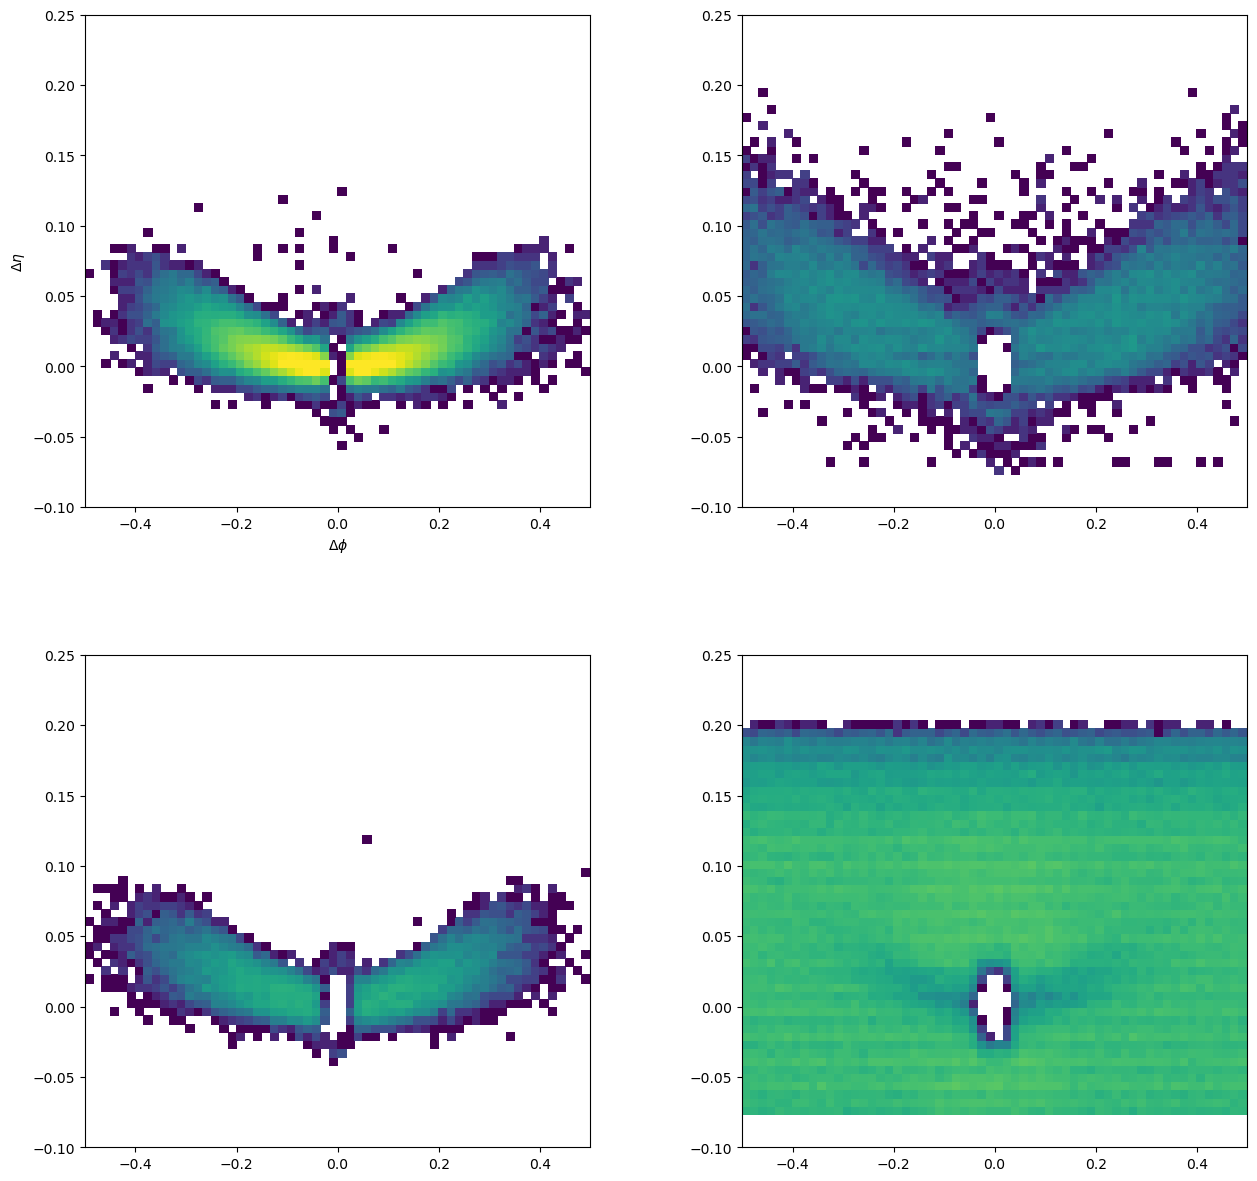

In [14]:
fig, ((ax,ay), (bx,by)) = plt.subplots(2,2, figsize=(15,15), dpi=100)
plt.subplots_adjust( hspace=0.3, wspace=0.3)


brange =((-0.5,0.5), (-0.1, 0.25))
nbins=(60,60)

A = ax.hist2d( IN_T[:,1], IN_T[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm( vmin=1, vmax=1500))
amax = np.max(A[0])
ay.hist2d( OUT_T[:,1], OUT_T[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm(vmin=1, vmax=1500))

bx.hist2d( IN_F[:,1], IN_F[:,0], bins=nbins, range=brange,cmin=1,  norm=colors.LogNorm(vmin=1, vmax=1500))
im = by.hist2d( OUT_F[:,1], OUT_F[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm(vmin=1, vmax=1500))

for a in [ax,ay, bx,by]:
    a.set_xlabel("$\Delta\phi$")
    a.set_ylabel("$\Delta\eta$")
    hep.cms.label(llabel="Simulation", rlabel='14 TeV',loc=0, ax=a)
    
x = 0.05
y = 0.88
ax.text(x,y, "DeepSC: clustered ele/$\gamma$", transform=ax.transAxes,  fontsize=23)
ay.text(x,y, "DeepSC: rejected ele/$\gamma$", transform=ay.transAxes,  fontsize=23)
bx.text(x,y, "DeepSC: clustered PU/noise", transform=bx.transAxes,  fontsize=23)
by.text(x,y, "DeepSC: rejected PU/noise", transform=by.transAxes,  fontsize=23)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im[3], cax=cbar_ax, label="N. clusters")

In [ ]:
fig, ((ax,ay), (bx,by)) = plt.subplots(2,2, figsize=(15,15), dpi=100)
plt.subplots_adjust( hspace=0.3, wspace=0.3)


brange =((-0.5,0.5), (-0.1, 0.25))
nbins=(60,60)

A = ax.hist2d( INM_T[:,1], INM_T[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm( vmin=1, vmax=1500))
amax = np.max(A[0])
ay.hist2d( OUTM_T[:,1], OUTM_T[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm(vmin=1, vmax=1500))

bx.hist2d( INM_F[:,1], INM_F[:,0], bins=nbins, range=brange,cmin=1,  norm=colors.LogNorm(vmin=1, vmax=1500))
im = by.hist2d( OUTM_F[:,1], OUTM_F[:,0], bins=nbins, range=brange,cmin=1, norm=colors.LogNorm(vmin=1, vmax=1500))

for a in [ax,ay, bx,by]:
    a.set_xlabel("$\Delta\phi$")
    a.set_ylabel("$\Delta\eta$")
    hep.cms.label(llabel="Simulation", rlabel='14 TeV',loc=0, ax=a)
    
x = 0.05
y = 0.88
ax.text(x,y, "Mustache: clustered ele/$\gamma$", transform=ax.transAxes,  fontsize=23)
ay.text(x,y, "Mustache: rejected ele/$\gamma$", transform=ay.transAxes,  fontsize=23)
bx.text(x,y, "Mustache: clustered PU/noise", transform=bx.transAxes,  fontsize=23)
by.text(x,y, "Mustache: rejected PU/noise", transform=by.transAxes,  fontsize=23)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(im[3], cax=cbar_ax, label="N. clusters")